In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import glob
import random

from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

In [3]:
from tqdm import tqdm
from tqdm.notebook import tqdm, trange

In [4]:
fonts_folder = "../fonts"

fonts = glob.glob(fonts_folder + "/*.ttf")

In [17]:
def generate_image(font_path: str, target: int = None) -> tuple[Image, int]:
    color = random.randint(230, 255)
    
    # Generate image
    img = Image.new("L", (256, 256))

    if target is None:
        target = random.randint(0, 9)
    
    size = random.randint(230, 250)
    x = random.randint(50, 70)
    y = random.randint(15, 25)

    font = ImageFont.truetype(fonts[0], size)
    
    draw = ImageDraw.Draw(img)
    draw.text((x, y), str(target), color, font=font)
    
    img = img.resize((28, 28), Image.BILINEAR)
    
    return img, target

In [18]:
img, target = generate_image(fonts[0], target=1)

In [19]:
img

In [8]:
import matplotlib.pyplot as plt

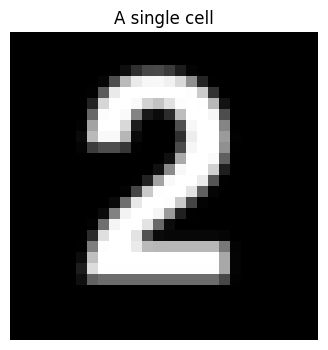

In [9]:
plt.figure(figsize=(4, 4))
plt.axis('off') # Removes axis
plt.imshow(img, cmap='gray')
plt.title("A single cell");

In [10]:
import numpy as np

In [11]:
N_train = 60000
N_val = 1000

# DATASET_FOLDER = "../data/realistic_mnist"

# Path(DATASET_FOLDER).mkdir(exist_ok=True)

# Generate training set
y_tr = []
X_tr = []

for i in trange(N_train):
    img, target = generate_image(fonts[0])
    X_tr.append(np.array(img).ravel())

    y_tr.append(target)
    # img_path = Path(DATASET_FOLDER) / f"{target}_{i}.png"
    # img.save(img_path)

X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

# Sanity checks
assert X_tr.shape == (N_train, 784)
assert y_tr.shape == (N_train, )

# Generate test set
y_val = []
X_val = []

for i in trange(N_val):
    img, target = generate_image(fonts[0])
    X_val.append(np.array(img).ravel())

    y_val.append(target)

X_val = np.array(X_val)
y_val = np.array(y_val)

# Sanity checks
assert X_val.shape == (N_val, 784)
assert y_val.shape == (N_val, )

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier())])

#input data normalization
scaler = StandardScaler()
scaler.fit(X_tr)

X_tr_scaled=scaler.transform(X_tr)
X_val_scaled=scaler.transform(X_val)

### TODO ###
# Train a classifier which uses the MLPClassifier and print its accuracy
# WARNING: use the scaled features both when training and when testing the model

mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_tr_scaled, y_tr)
y_pred = mlp_classifier.predict(X_val_scaled)

print("Accuracy of model MLPClassifier = %2f%%" % (accuracy_score(y_val, y_pred )*100))

### END ###

Accuracy of model MLPClassifier = 100.000000%


In [14]:
ARTIFACTS_DIR = "../artifacts"

In [15]:
best_model = mlp_classifier

In [16]:
import pickle

# Use pickle to save model for next usage.

# Create folder if it does not exist
Path(ARTIFACTS_DIR).mkdir(exist_ok=True)

best_model_path = Path(ARTIFACTS_DIR) / 'bestest_model_sklearn.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f) 

In [ ]:
1/0

In [21]:
from phd_school.dataset import PrintedMNIST, AddGaussianNoise, AddSPNoise

In [49]:
import torch
from timm import create_model
from torchvision import transforms, datasets
import lightning as L
import torch.nn as nn

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # AddGaussianNoise(0, 1.0),
    AddSPNoise(0.1),
])

val_transforms = transforms.Compose([transforms.ToTensor()])


# DEFAULT_TRANSFORM = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

class LitClassification(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = create_model('resnet34', num_classes=10)


        # Replace 1st layer to use it on grayscale images
        self.model.conv1 = nn.Conv2d(
            1,
            64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False,
        )

        
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def training_step(self, batch):
        images, targets = batch
        outputs = self.model(images)
        loss = self.loss_fn(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def forward(self, x):
        return self.model(x)
        

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.005)
    
    
class ClassificationData(L.LightningDataModule):

    def train_dataloader(self):
        train_dataset = PrintedMNIST(320, -666, transform=train_transform)
        
        return torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5)
    

In [40]:
model = LitClassification()
data = ClassificationData()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 21.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.134    Total estimated model params size (MB)
167       Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [46]:
trainer.save_checkpoint("best_model.ckpt")

In [ ]:
model = LitClassification.load_from_checkpoint("best_model.ckpt")
model.eval()

In [80]:
img, target = generate_image(fonts[0], target=0)

In [81]:
with torch.no_grad():
    out = model(val_transforms(img).unsqueeze(0))
    _, P = torch.max(out, 1)

    digit = P.item()
    print(digit)

8


In [56]:
out

tensor([[-2.6940,  1.4751, -0.5719,  0.2334,  0.8861, -0.4532, -0.3965, -0.3106,
         -0.2303, -0.7476]])

1

In [54]:
img